### MAST30034: Applied Data Science Project 1
---
# Data Analysis: Modelling Average Trip Distance Over Time
#### Xavier Travers (1178369)

TODO: Modelling Average Trip Distance Over Time

In [1]:
# imports used throughout this notebook
from collections import defaultdict
from itertools import product
import os
import sys
from pyspark.sql import DataFrame, Column
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F
import geopandas

# add homemade helpers
sys.path.insert(1, '../scripts')
import helpers.join_helpers as jh
import helpers.plot_helpers as ph

# for printouts
DEBUGGING = False

In [2]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName('MAST30034 XT Project 1')
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.sql.repl.eagerEval.enabled', True) 
    .config('spark.sql.parquet.cacheMetadata', 'true')
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/08/15 20:13:27 WARN Utils: Your hostname, Polaris resolves to a loopback address: 127.0.1.1; using 172.22.165.153 instead (on interface eth0)
22/08/15 20:13:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/15 20:13:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Grouped by Pick-Up Location

In [3]:
# read in the aggregated tlc by pickup data
tlc_pu_df = spark.read.parquet('../data/curated/tlc/aggregated/yellow/by_pu')
tlc_pu_df.limit(5)

week_year,week_month,week_ending,week_index,timeline,pu_borough,population,num_trips,num_pc_trips,num_p100k_trips,avg_passengers,avg_trip_distance
2020,4,2020-04-25,121,keep for graphing,Queens,2395791.0,1612,6.728466715168394E-4,67.28466715168393,1.1457816377171215,6.7971650124069445
2020,4,2020-04-04,118,keep for graphing,Queens,2395791.0,2342,9.775477076255817E-4,97.75477076255817,1.2314261315115287,7.5416652433817255
2020,7,2020-07-25,134,post,Brooklyn,2727393.0,1930,7.076354599428832E-4,70.76354599428832,1.2279792746113989,2.8218341968911953
2020,6,2020-06-13,128,post,Brooklyn,2727393.0,1313,4.814121030595884E-4,48.14121030595884,1.300837776085301,3.505689261233818
2020,4,2020-04-04,118,keep for graphing,Manhattan,1687834.0,51640,0.030595425853490333,3059.5425853490333,1.2797637490317584,2.3961254841208284


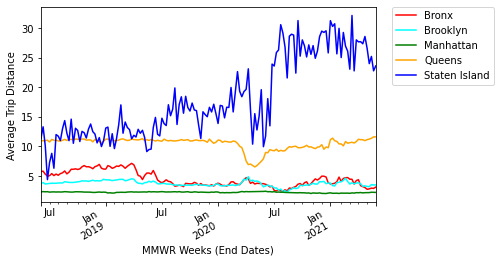

In [4]:
# generate a time series graph of daily avg trips vs week index.
ph.time_series(tlc_pu_df.toPandas(), 'avg_trip_distance', 
    ylabel = 'Average Trip Distance')

Note that there appears to be no data past March 2021.
This is likely due to 

### Grouped by Drop-Off Location

In [5]:
# read in the aggregated tlc by dropoff data
tlc_do_df = spark.read.parquet('../data/curated/tlc/aggregated/yellow/by_do')
tlc_do_df.limit(5)

week_year,week_month,week_ending,week_index,timeline,do_borough,population,num_trips,num_pc_trips,num_p100k_trips,avg_passengers,avg_trip_distance
2020,4,2020-04-25,121,keep for graphing,Queens,2395791.0,2203,9.195292911610404E-4,91.95292911610403,1.2437585111211984,5.715932818883344
2020,4,2020-04-04,118,keep for graphing,Queens,2395791.0,2761,0.001152437754378...,115.24377543784078,1.2520825787758059,6.387388627308936
2020,7,2020-07-25,134,post,Brooklyn,2727393.0,7262,0.002662615911971...,266.2615911971615,1.3416414210961167,6.8881575323602195
2020,6,2020-06-13,128,post,Brooklyn,2727393.0,4440,0.001627928208366...,162.7928208366011,1.3353603603603603,7.001590090090083
2020,4,2020-04-04,118,keep for graphing,Manhattan,1687834.0,48577,0.028780673928834235,2878.0673928834235,1.2804207752640138,2.117848570311032


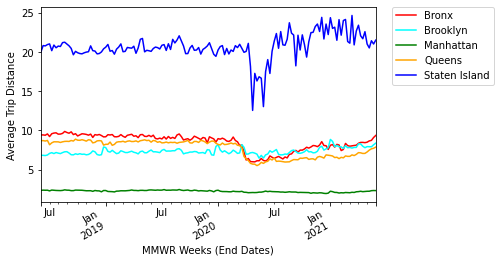

In [6]:
# generate a time series graph of daily avg trips vs week index.
ph.time_series(tlc_do_df.toPandas(), 'avg_trip_distance', 
    ylabel = 'Average Trip Distance')